In [66]:
# import pandas as pd
# import numpy as np
# import re
# import nltk
# from nltk.corpus import stopwords
# from gensim.models import Word2Vec
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping

In [67]:
# # Step 1: Load and preprocess
# nltk.download('stopwords')
# df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
# df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
# stopwords_set = set(stopwords.words('english'))

In [68]:
# def clean_lyrics(text):
#     text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
#     tokens = text.split()
#     return ' '.join([t for t in tokens if t not in stopwords_set])

In [69]:
# df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
# df = df[df['genre'].map(df['genre'].value_counts()) > 1]

In [70]:
# # Step 2: Tokenize and embed
# tokenized = df['cleaned_lyrics'].apply(str.split)
# w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
# valid_words = set(w2v_model.wv.index_to_key)

In [71]:
# # Build tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df['cleaned_lyrics'])
# filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
# tokenizer.word_index = filtered_index
# tokenizer.index_word = {i: word for word, i in filtered_index.items()}

# # Convert lyrics
# sequences = tokenizer.texts_to_sequences(df['cleaned_lyrics'])
# X_lyrics = pad_sequences(sequences, maxlen=300)

In [72]:
# embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
# for word, i in filtered_index.items():
#     embedding_matrix[i] = w2v_model.wv[word]

# # Labels
# le = LabelEncoder()
# y = to_categorical(le.fit_transform(df['genre']))

# X_train, X_test, y_train, y_test = train_test_split(X_lyrics, y, test_size=0.2, stratify=y, random_state=42)
# print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

In [73]:
# # Step 3: Run GRU experiments
# best_val_acc = 0
# best_config = None
# results = []

# hidden_units = [32, 64, 128]
# dropouts = [0.2,0.4]
# layer_depths = [1, 2]  # single vs stacked GRUs

# for units in hidden_units:
#     for dropout_rate in dropouts:
#         for depth in layer_depths:
#             print(f"\nTraining GRU model: units={units}, dropout={dropout_rate}, layers={depth}")
#             input_ = Input(shape=(300,))
#             x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
#                             weights=[embedding_matrix], trainable=False)(input_)
#             for _ in range(depth - 1):
#                 x = Bidirectional(GRU(units, return_sequences=True))(x)
#                 x = Dropout(dropout_rate)(x)
#             x = Bidirectional(GRU(units))(x)
#             x = Dropout(dropout_rate)(x)
#             output = Dense(y.shape[1], activation='softmax')(x)

#             model = Model(inputs=input_, outputs=output)
#             model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#             early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
#             history = model.fit(
#                 X_train, y_train,
#                 validation_data=(X_test, y_test),
#                 batch_size=64,
#                 epochs=30,
#                 callbacks=[early_stop],
#                 verbose=2
#             )

#             final_acc = max(history.history['val_accuracy'])
#             print(f"Final val accuracy: {final_acc:.4f}")
#             results.append((units, dropout_rate, depth, final_acc))
#             if final_acc > best_val_acc:
#                 best_val_acc = final_acc
#                 best_config = (units, dropout_rate, depth)
#                 best_model = model

In [74]:
# print("\nSummary of Experiments:")
# for units, dropout, depth, acc in results:
#     print(f"units={units}, dropout={dropout}, layers={depth} → val_acc={acc:.4f}")
# print(f"\nBest config: GRU({best_config[0]}) dropout={best_config[1]}, layers={best_config[2]} → val_acc={best_val_acc:.4f}")

### NEW HYPERPARAM TUNE WITH CLASS WEIGHTS ###

In [80]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [81]:
# Step 1: Load and preprocess
nltk.download('stopwords')
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

SEED = 42
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

In [83]:
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
# df = df[df['genre'].map(df['genre'].value_counts()) > 20]
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]
print(len(df['genre']))

major_class = 'Rock'
df_major = df[df['genre'] == major_class]
df_minor = df[df['genre'] != major_class]

# Downsample major class
df_major_downsampled = resample(df_major,
                                replace=False,
                                n_samples=int(df_minor.shape[0] / (len(valid_genres) - 1)),
                                random_state=42)

# Combine back
df_balanced = pd.concat([df_major_downsampled, df_minor])
df = df_balanced.sample(frac=1, random_state=42)  # Shuffle

# Step 2: Tokenize and embed
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

# Build tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

# Convert lyrics
sequences = tokenizer.texts_to_sequences(df['cleaned_lyrics'])
X_lyrics = pad_sequences(sequences, maxlen=300)

embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

# Labels
le = LabelEncoder()
y_labels = le.fit_transform(df['genre'])
y = to_categorical(y_labels)

# # Hold out a true test set
# X_temp, X_final_test, y_temp, y_final_test, y_temp_labels, y_final_labels = train_test_split(
#     X_lyrics, y, y_labels, test_size=0.05, stratify=y_labels, random_state=42
# )

# # Remaining split
# X_train, X_val, y_train, y_val, y_train_labels, y_val_labels = train_test_split(
#     X_temp, y_temp, y_temp_labels, test_size=0.2, stratify=y_temp_labels, random_state=42
# )


# Define meta features and prepare meta input
meta_features = ['duration','tempo','key','loudness',
    'pitch_mean_0','pitch_std_0','timbre_mean_0','timbre_std_0',
    'pitch_mean_1','pitch_std_1','timbre_mean_1','timbre_std_1',
    'pitch_mean_2','pitch_std_2','timbre_mean_2','timbre_std_2',
    'pitch_mean_3','pitch_std_3','timbre_mean_3','timbre_std_3',
    'pitch_mean_4','pitch_std_4','timbre_mean_4','timbre_std_4',
    'pitch_mean_5','pitch_std_5','timbre_mean_5','timbre_std_5',
    'pitch_mean_6','pitch_std_6','timbre_mean_6','timbre_std_6',
    'pitch_mean_7','pitch_std_7','timbre_mean_7','timbre_std_7',
    'pitch_mean_8','pitch_std_8','timbre_mean_8','timbre_std_8',
    'pitch_mean_9','pitch_std_9','timbre_mean_9','timbre_std_9',
    'pitch_mean_10','pitch_std_10','timbre_mean_10','timbre_std_10',
    'pitch_mean_11','pitch_std_11','timbre_mean_11','timbre_std_11']
df[meta_features] = df[meta_features].fillna(0)
X_meta = df[meta_features].values
scaler = StandardScaler()
X_meta = scaler.fit_transform(df[meta_features].fillna(0))

# Split everything using same stratified labels
# Use 70% train, 15% val, 15% test
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X_lyrics, X_meta, y, y_labels, test_size=0.3, stratify=y_labels, random_state=42
)

X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=0.5, stratify=y_temp_labels, random_state=42
)


# Rename for consistency
X_train, X_val, X_test = X_train_lyrics, X_val_lyrics, X_test_lyrics
print(X_train_lyrics.shape)
print(X_val_lyrics.shape)
print(X_test_lyrics.shape)


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

1047
(457, 300)
(98, 300)
(98, 300)



Training GRU+Metadata model: units=16, dropout=0.2, layers=1
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.0484 - loss: 3.1258 - val_accuracy: 0.0408 - val_loss: 2.9532
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0661 - loss: 2.9742 - val_accuracy: 0.0714 - val_loss: 2.8297
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0795 - loss: 2.8197 - val_accuracy: 0.1633 - val_loss: 2.7234
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1322 - loss: 2.7089 - val_accuracy: 0.1837 - val_loss: 2.6323
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1438 - loss: 2.6763 - val_accuracy: 0.2449 - val_loss: 2.5521
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1652 - loss: 2.5868 - val_accuracy: 0.2551 - val_loss: 2.4868
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2089 - loss: 2.4658 - val_accuracy: 0.2755 - val_loss: 2.4298
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.

/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

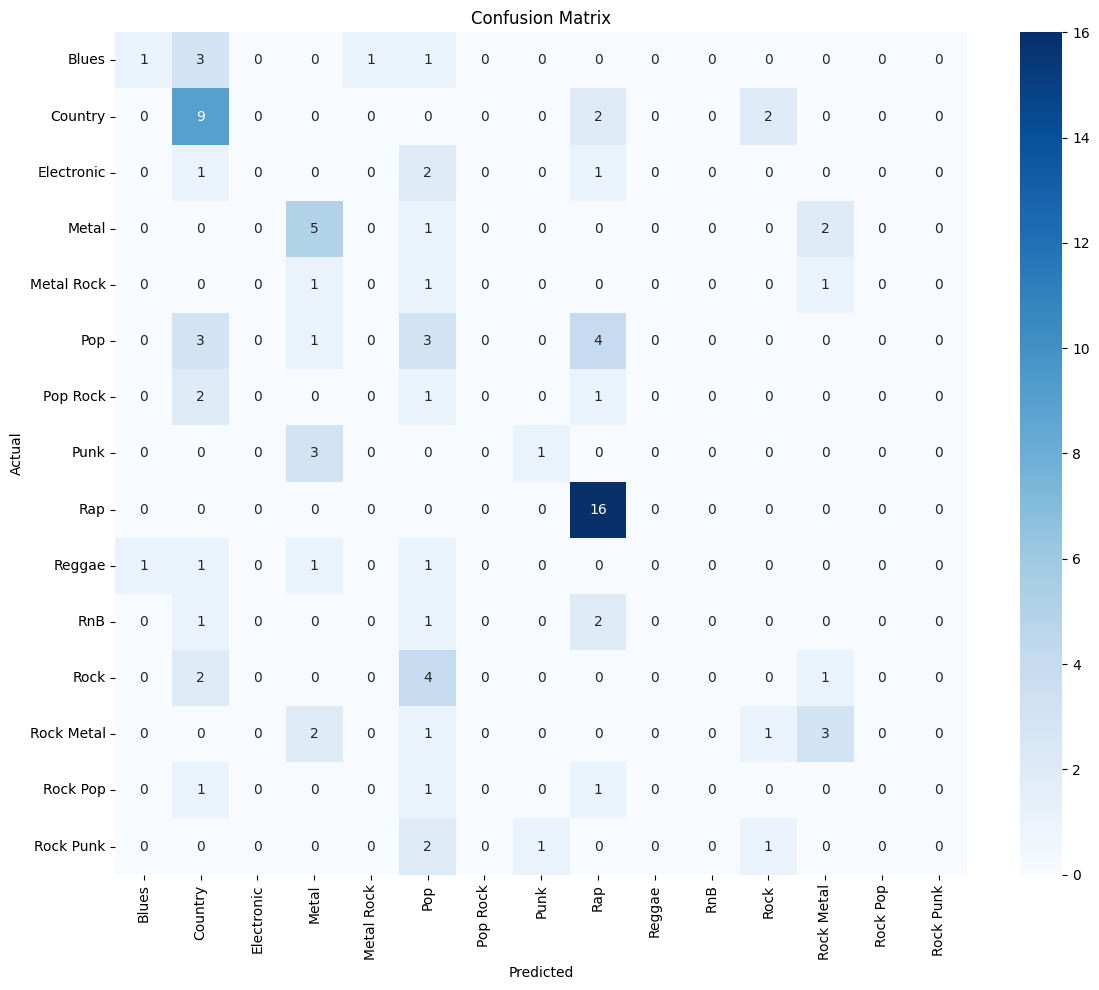

In [84]:
# Define a curated list of hyperparameter combinations to explore
gru_configs = [
    (16, 0.2, 1), (32, 0.2, 1), (64, 0.2, 1), (96, 0.2, 1), (128, 0.2, 1), (256, 0.2, 1),
    (64, 0.3, 1), (96, 0.3, 1), (128, 0.3, 1),
    (64, 0.4, 2), (96, 0.4, 2), (128, 0.4, 2), (256, 0.4, 2),
    (64, 0.5, 2), (96, 0.5, 2), (128, 0.5, 2),
    (64, 0.3, 3), (96, 0.3, 3),
    (128, 0.5, 3), (256, 0.5, 3),
    (128, 0.7, 2), (256, 0.7, 2),
    (256, 0.3, 1), (256, 0.3, 3),
]

best_val_acc = 0
best_config = None
best_model = None

for units, dropout_rate, depth in gru_configs:
    print(f"\nTraining GRU+Metadata model: units={units}, dropout={dropout_rate}, layers={depth}")

    # Define lyric input
    input_lyrics = Input(shape=(X_train.shape[1],))  # shape=(100,) or (300,) depending on context
    x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50, weights=[embedding_matrix], trainable=False)(input_lyrics)
    for _ in range(depth - 1):
        x = Bidirectional(GRU(units, return_sequences=True))(x)
        x = Dropout(dropout_rate)(x)
    x = Bidirectional(GRU(units))(x)
    x = Dropout(dropout_rate)(x)

    # Define metadata input
    input_meta = Input(shape=(X_train_meta.shape[1],))
    combined = Concatenate()([x, input_meta])
    out = Dense(y.shape[1], activation='softmax')(combined)

    model = Model(inputs=[input_lyrics, input_meta], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=0)
    history = model.fit(
        [X_train, X_train_meta], y_train,
        validation_data=([X_val, X_val_meta], y_val),
        batch_size=64, epochs=20,
        callbacks=[early_stop], verbose=1
    )

    val_acc = max(history.history['val_accuracy'])
    print(f"Val Accuracy: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = (units, dropout_rate, depth)
        best_model = model

# Evaluation
print(f"\nBest Config → GRU({best_config[0]}), Dropout={best_config[1]}, Layers={best_config[2]}")
print("\nEvaluating best model on test set...")
y_pred = np.argmax(best_model.predict([X_test, X_test_meta]), axis=1)
test_acc = accuracy_score(y_test_labels, y_pred)
print(f"Test Accuracy on held-out set: {test_acc:.4f}")

# Print sample predictions
sample_idxs = np.random.choice(len(X_test), size=5, replace=False)
for i in sample_idxs:
    print(f"\nSample {i}")
    print("Actual Genre   :", le.inverse_transform([y_test_labels[i]])[0])
    print("Predicted Genre:", le.inverse_transform([y_pred[i]])[0])

# Confusion matrix and classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [85]:
# Summary
print(f"\nBest config: GRU({best_config[0]}), dropout={best_config[1]}, layers={best_config[2]} → val_acc={best_val_acc:.4f}")


Best config: GRU(256), dropout=0.3, layers=1 → val_acc=0.4286


In [86]:
# Evaluate best model with and without class weights
units, dropout_rate, depth = best_config

In [87]:
from tensorflow.keras.callbacks import EarlyStopping

# Rebuild model function
def build_gru_metadata_model(units, dropout_rate, depth, input_shape_lyrics, input_shape_meta, output_dim):
    input_lyrics = Input(shape=input_shape_lyrics)
    x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50, weights=[embedding_matrix], trainable=False)(input_lyrics)
    for _ in range(depth - 1):
        x = Bidirectional(GRU(units, return_sequences=True))(x)
        x = Dropout(dropout_rate)(x)
    x = Bidirectional(GRU(units))(x)
    x = Dropout(dropout_rate)(x)

    input_meta = Input(shape=input_shape_meta)
    combined = Concatenate()([x, input_meta])
    out = Dense(output_dim, activation='softmax')(combined)

    model = Model(inputs=[input_lyrics, input_meta], outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ==== RETRAIN WITHOUT CLASS WEIGHTS ====
print("\nRetraining best model WITHOUT class weights...")
model_no_weights = build_gru_metadata_model(
    units=best_config[0], dropout_rate=best_config[1], depth=best_config[2],
    input_shape_lyrics=(X_train.shape[1],), input_shape_meta=(X_train_meta.shape[1],), output_dim=y.shape[1]
)

model_no_weights.fit([X_train, X_train_meta], y_train,
                     validation_data=([X_val, X_val_meta], y_val),
                     batch_size=64, epochs=20,
                     callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
                     verbose=1)

y_pred_no_weights = np.argmax(model_no_weights.predict([X_test, X_test_meta]), axis=1)
acc_no_weights = accuracy_score(y_test_labels, y_pred_no_weights)

# ==== RETRAIN WITH CLASS WEIGHTS ====
print("\nRetraining best model WITH class weights...")
model_with_weights = build_gru_metadata_model(
    units=best_config[0], dropout_rate=best_config[1], depth=best_config[2],
    input_shape_lyrics=(X_train.shape[1],), input_shape_meta=(X_train_meta.shape[1],), output_dim=y.shape[1]
)

model_with_weights.fit([X_train, X_train_meta], y_train,
                       validation_data=([X_val, X_val_meta], y_val),
                       batch_size=64, epochs=20,
                       callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
                       class_weight=class_weight_dict,
                       verbose=1)

y_pred_with_weights = np.argmax(model_with_weights.predict([X_test, X_test_meta]), axis=1)
acc_with_weights = accuracy_score(y_test_labels, y_pred_with_weights)

# ==== Results ====
print("\n🎯Final Test Accuracy:")
print(f"Without class weights → {acc_no_weights:.4f}")
print(f"With class weights    → {acc_with_weights:.4f}")



Retraining best model WITHOUT class weights...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.1165 - loss: 2.7001 - val_accuracy: 0.2449 - val_loss: 2.4075
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.2061 - loss: 2.4349 - val_accuracy: 0.3163 - val_loss: 2.3225
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.2308 - loss: 2.3931 - val_accuracy: 0.3265 - val_loss: 2.2594
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - accuracy: 0.3046 - loss: 2.2757 - val_accuracy: 0.3265 - val_loss: 2.1757
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.2634 - loss: 2.5618 - val_accuracy: 0.3367 - val_loss: 2.1844
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.2721 - loss: 2.1873 - val_accuracy: 0.3571 - val_loss: 2.1368
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.3770 - loss: 2.0631 - val_accuracy: 0.3776 - val_loss: 2.1009
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.3851 -

In [88]:
print("\nSample Predictions (With Class Weights):\n")

# Map genre index to name
index_to_genre = dict(enumerate(le.classes_))

# Pick 5 random test indices
sample_indices = np.random.choice(len(X_test), size=5, replace=False)

for i in sample_indices:
    true_genre = index_to_genre[y_test_labels[i]]
    predicted_genre = index_to_genre[y_pred_with_weights[i]]

    # Try to get raw lyrics for reference (if df was shuffled, grab from X_test_lyrics)
    sequence = X_test[i]
    # Convert token indices back to words
    inverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    decoded_words = [inverse_word_map.get(token, '') for token in sequence if token > 0]
    raw_lyrics = ' '.join(decoded_words)

    print(f"--- Sample {i} ---")
    print(f"Lyrics (truncated): {raw_lyrics[:200]}...")
    print(f"True Genre        : {true_genre}")
    print(f"Predicted Genre   : {predicted_genre}")
    print()



Sample Predictions (With Class Weights):

--- Sample 81 ---
Lyrics (truncated): like like come oh oh oh get get get get see got got never let way say take take take take take yeah yeah back look look look look look caus gonna gonna tri well well well well well well well well well...
True Genre        : Rock Punk
Predicted Genre   : Pop Rock

--- Sample 37 ---
Lyrics (truncated): know know one get get want want back need need dream wo fall light everi home walk tonight hard put true close must must cold side side door death ask ask wind goe goe step blow drive carri carri slow...
True Genre        : Metal
Predicted Genre   : Metal

--- Sample 77 ---
Lyrics (truncated): love love love love love love love love love know know know know know know know know know know know know know know know know know know ca back back fall wait wait wait wait wait wait wait wait hold ho...
True Genre        : Electronic
Predicted Genre   : Rock Metal

--- Sample 91 ---
Lyrics (truncated): love one never ne